### Gaussian Mixture Model

&nbsp;

Gaussian Mixture Model is another form of unsupervised learning. Mathematically, it is somewhat similar to Gaussian Discriminant Analysis. In GDA, we can predict a new data point based upon p(y) and p(x|y=label) where p(y) is the prior probability of a data point belongs to one specific label and p(x|y=label) is the probability density function of Gaussian distribution under the label. The concept holds in GMM. 

From the perspective of GMM, the metadata consists of data points belong to different labels. Each label follows a multivariate Gaussian distribution with unique mean and covariance matrix. However, GMM is an unsupervised learning which indicates we do not have training dataset to compute p(y). p(y) is crucial to a follow-up computation of μ and Σ in Gaussian distribution, yet it remains a latent variable we do not observe. In order to estimate p(y), we need to take an initial guess and gradually converge to the optimal number throughout iterations. This is when the algorithm called Expectation-Maximization kicks in and saves the day.

The material from Stanford university is the Bible of machine learning. It did an excellent job on the derivation of EM algorithm, but it didn’t cover much about the mathematics of Gaussian Mixture Model. I will recommend the following materials as a supplementary to the Bible.

Detailed explanation on Gaussian Mixture Model

https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

Detailed notebook on EM algorithm and Jensen’s inequality

http://krasserm.github.io/2019/11/21/latent-variable-models-part-1/

Reference to Gaussian Discriminant Analysis

https://github.com/je-suis-tm/machine-learning/blob/master/gaussian%20discriminant%20analysis.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.mixture
import sklearn.decomposition
import pandas as pd

In [2]:
#official sklearn gmm
def skl_gmm(df,xcols,num_of_clusters,diagnosis=False):
    
    data=df.copy()
    
    clf=sklearn.mixture.GaussianMixture(num_of_clusters,
                                        init_params='random')
    clf.fit(data[xcols])
    
    if diagnosis:
        print(f'{clf.n_iter_} iterations to reach convergence\n')
    
    data['label']=np.argmax(clf.predict_proba(data[xcols]),axis=1)
    
    #compute accuracy
    erreur=0
    checked=[]
    for i in data['y'].unique():
        erreur+=get_accuracy(data,i,checked)
        checked.append(i)
    accuracy=1-erreur/len(df)
    if diagnosis:
        print('\naccuracy: %s'%(accuracy))

    return clf.means_,clf.covariances_, \
clf.weights_,clf.predict_proba(data[xcols])

In [3]:
#for unsupervised learning, clf.score doesnt return the accuracy
#there is no cross validation, no known labels
#the only way to detect the accuracy is vote of the majority
#for each label given
#we check which iris type is the majority
#we consider the majority as the correct classification
#all we need to do is to count the minority
def get_accuracy(data,class_,checked):
    
    df=data.copy()
    
    #use dictionary to keep track of everything
    d={}
    
    #counting
    for i in df['label'][df['y']==class_].unique():
        if i not in checked and i!=-1:
            d[i]=df['label'][df['y']==class_].tolist().count(i)

    #comparison
    large=-1
    lbl=None
    for i in d:
        if d[i]>large:
            lbl=i
            large=d[i]

    return len(df['label'][df['y']==class_][df['label']!=lbl])

In [4]:
#initialize random miu, sigma and weight for each gaussian
#you can use random number like i do
#or use kmeans centroids which is more computation expensive
def init_params(df,num_of_clusters):
    
    mean_vec=[];cov_mat=[];w_vec=[]

    for _ in range(num_of_clusters):
        mean_vec.append(
            df.loc[np.random.choice(len(df),10)].mean().tolist())
        cov_mat.append(np.diag([1]*len(df.columns)))
        w_vec.append(1/num_of_clusters)
    
    return (mean_vec,cov_mat,w_vec)

In [5]:
#pdf of multivariate gaussian
#equivalent to scipy.stats.multivariate_normal(miu,sigma).pdf(X)
def multivariate_gaussian(data,miu,sigma):
    
    numerator=np.exp(-0.5*(
        np.mat(data)-miu)*np.linalg.inv(sigma)*(np.mat(data)-miu).T)

    denominator=(2*np.pi)**(data.shape[1]/2)*np.linalg.det(sigma)**0.5

    return np.diagonal(numerator/denominator)

In [6]:
#e step
#compute the posterior probability with given params
def e_step(data,num_of_clusters,params):
    
    #unpack params
    mean_vec,cov_mat,w_vec=params
    
    collections={}
    posterior={}
    
    #Bayes rule
    for i in range(num_of_clusters):        
        
        collections[i]=multivariate_gaussian(data,mean_vec[i],cov_mat[i])*w_vec[i]
    
    #compute posterior
    for i in range(num_of_clusters):
        
        posterior[i]=collections[i]/np.sum([collections[i] for i in collections],axis=0)
        
    return posterior

In [7]:
#m step
#use posterior probability to update params
def m_step(data,num_of_clusters,params,posterior):
    
    #unpack params
    mean_vec,cov_mat,w_vec=params
    
    #solving lagrangian by partial derivatives
    for i in range(num_of_clusters):

        mean_vec[i]=np.sum(
            np.multiply(
                np.mat(data),
                posterior[i].reshape(-1,1),),axis=0)/sum(posterior[i]).T
        
        cov_mat[i]=np.multiply(
            posterior[i].reshape(-1,1),
            (np.mat(data)-mean_vec[i])).T*(
            np.mat(data)-mean_vec[i])/sum(posterior[i])
        
        w_vec[i]=posterior[i].mean()
        
    return (mean_vec,cov_mat,w_vec)

In [8]:
#using jensens inequality to compute the lower bound
#which is the function of the expectation
def get_lower_bound(data,num_of_clusters,params,posterior):
    
    #unpack params
    mean_vec,cov_mat,w_vec=params
    
    lowerbound=0

    for i in range(num_of_clusters):

        #log pdf of multivariate gaussian
        logpdf=np.log(multivariate_gaussian(data,mean_vec[i],cov_mat[i]))
        
        #use bayes rules to decompose the numerator of the lower bound
        lowerbound+=np.sum(
            posterior[i]*(logpdf+np.log(w_vec[i])-np.log(posterior[i])))

    return lowerbound

In [9]:
#using mle for training
def training(data,num_of_clusters,
             tolerance=0.001,num_of_itr=50,diagnosis=False):
    
    #initialize
    lower_bound_old=None
    lower_bound=None
    counter=0    
    
    #initial parameters
    params=init_params(data,num_of_clusters)

    #cap the maximum number of iterations
    while counter<num_of_itr:
        
        try:
            
            #e step
            posterior=e_step(data,num_of_clusters,params)
            
            #m step
            params=m_step(data,num_of_clusters,params,posterior)
            
            #use lower bound to determine if converged
            lower_bound_old=lower_bound
            lower_bound=get_lower_bound(data,num_of_clusters,params,posterior)

            if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
                
                if diagnosis:
                    print(f'{counter} iterations to reach convergence\n')
                return params
            
            counter+=1
        
        #reboot everything when singular matrix is encountered
        except np.linalg.LinAlgError:
            
            params=init_params(data,num_of_clusters)
            lower_bound_old=None
            lower_bound=None
            counter=0
    
    if diagnosis:
        print(f'{counter} iterations to reach convergence\n')
        
    return params

In [10]:
#the main function
def gmm(df,xcols,num_of_clusters,
        tolerance=0.001,num_of_itr=50,diagnosis=False):
    
    data=df.copy()
    
    #obtain parameters of gmm
    params=training(data[xcols],num_of_clusters,
                    tolerance,num_of_itr,diagnosis)
    
    #compute the prediction probability
    posterior=e_step(data[xcols],num_of_clusters,params)
    
    #make forecast based upon probability
    data['label']=np.argmax(
          np.concatenate(
              [posterior[i].reshape(-1,1) for i in posterior],axis=1),1)
    
    #compute accuracy
    erreur=0
    checked=[]
    for i in data['y'].unique():
        erreur+=get_accuracy(data,i,checked)
        checked.append(i)
    accuracy=1-erreur/len(df)
    if diagnosis:
        print('\naccuracy: %s'%(accuracy))
    
    return params,posterior

In [11]:
#initialize number of clusters
num_of_clusters=3

In [12]:
#load data
iris=sklearn.datasets.load_iris()

#create dataframe
df=pd.DataFrame(iris.data,columns=iris.feature_names)
df['y']=iris.target

xcols=iris.feature_names

In [13]:
#the accuracy entirely depends on the initial parameters
#to obtain a better result
#the initial parameters should be generated by kmeans centroids
params,posterior=gmm(df,xcols,num_of_clusters,diagnosis=True)

15 iterations to reach convergence


accuracy: 0.84


In [14]:
#to level the playing field
#we are using random initial parameters in sklearn
miu,sigma,weight_gaussian,prob_gaussian= \
skl_gmm(df,xcols,num_of_clusters,diagnosis=True)

14 iterations to reach convergence


accuracy: 0.78


In [15]:
#mean comparison
print(params[0],'\n\n',miu)

[matrix([[5.00600031, 3.42800669, 1.46199645, 0.245995  ]]), matrix([[6.33380974, 2.68772305, 4.62903768, 1.41648825]]), matrix([[6.24236692, 2.92232959, 4.98157584, 1.74684726]])] 

 [[5.00623485 3.42852345 1.46207491 0.24597442]
 [6.3016641  2.75354375 4.77784322 1.46295965]
 [6.23091878 2.96243017 5.00260651 1.83849055]]


In [16]:
#covariance matrix comparison
print(params[1],'\n\n',sigma)

[matrix([[0.12176663, 0.09723391, 0.01602788, 0.01012392],
        [0.09723391, 0.14081754, 0.01146455, 0.00911303],
        [0.01602788, 0.01146455, 0.02955576, 0.00594712],
        [0.01012392, 0.00911303, 0.00594712, 0.01088312]]), matrix([[0.56529097, 0.14708111, 0.65033649, 0.22170147],
        [0.14708111, 0.09357417, 0.07091504, 0.02652935],
        [0.65033649, 0.07091504, 0.94237864, 0.3174626 ],
        [0.22170147, 0.02652935, 0.3174626 , 0.1111077 ]]), matrix([[0.39759079, 0.11838905, 0.40078107, 0.15664252],
        [0.11838905, 0.10219061, 0.14284535, 0.07698576],
        [0.40078107, 0.14284535, 0.57520702, 0.25229624],
        [0.15664252, 0.07698576, 0.25229624, 0.17367612]])] 

 [[[0.1217028  0.09701231 0.01599739 0.01014138]
  [0.09701231 0.14029193 0.01138451 0.0091445 ]
  [0.01599739 0.01138451 0.02955853 0.00595474]
  [0.01014138 0.0091445  0.00595474 0.01088854]]

 [[0.63630405 0.19544266 0.75715975 0.24144962]
  [0.19544266 0.14277862 0.20658867 0.07444944]
  [0

In [17]:
#prior probability comparison
print(params[2],'\n\n',weight_gaussian)

[0.33332396280474647, 0.14300775583353068, 0.5236682813617229] 

 [0.3331781  0.28909928 0.37772262]


In [18]:
#posterior probability comparison
print(np.concatenate(
    [posterior[i].reshape(-1,1) for i in posterior],
    axis=1),'\n\n',prob_gaussian)

[[9.99999988e-001 1.20274201e-008 4.70792632e-015]
 [9.99991268e-001 8.73143775e-006 1.73316927e-010]
 [9.99998946e-001 1.05387904e-006 6.06216278e-012]
 [9.99999987e-001 1.19230384e-008 7.55110179e-010]
 [1.00000000e+000 6.58718716e-013 1.37859263e-015]
 [1.00000000e+000 2.07968759e-015 5.27580548e-017]
 [1.00000000e+000 6.06936521e-015 3.50570830e-012]
 [9.99999997e-001 3.13047774e-009 2.91760507e-013]
 [9.99993973e-001 6.01165782e-006 1.51959895e-008]
 [9.99999941e-001 5.89408539e-008 2.65089953e-010]
 [9.99999999e-001 7.11578311e-010 5.36101035e-017]
 [1.00000000e+000 2.75470166e-015 7.09083463e-012]
 [9.99999408e-001 5.91338630e-007 4.89288429e-010]
 [9.99997245e-001 2.75356546e-006 1.12655397e-009]
 [9.99999982e-001 1.83813966e-008 5.26903077e-023]
 [1.00000000e+000 2.51143585e-023 3.37683608e-025]
 [9.99999999e-001 7.00732678e-010 7.97072229e-020]
 [9.99999760e-001 2.40292809e-007 5.65485655e-015]
 [9.99999968e-001 3.20118021e-008 6.08416726e-017]
 [1.00000000e+000 4.04454947e-0

In [19]:
#use pca to reduce dimensions
#check the link below for more details of pca
# https://github.com/je-suis-tm/machine-learning/blob/master/principal%20component%20analysis.ipynb   
dims=2
x=sklearn.decomposition.PCA(n_components=dims).fit_transform(df[xcols])

df['dim1']=x[:,0]
df['dim2']=x[:,1]

In [20]:
#prepare labels for viz
df['skl']=np.argmax(prob_gaussian,axis=1)

df['gmm']=np.argmax(
    np.concatenate(
        [posterior[i].reshape(-1,1) for i in posterior],
        axis=1),axis=1)

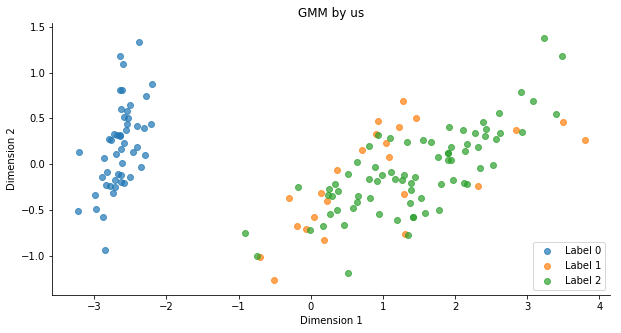

In [21]:
#self implementation viz
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in set(df['gmm']):
    plt.scatter(df['dim1'][df['gmm']==i],
                df['dim2'][df['gmm']==i],
                label=f'Label {int(i)}',alpha=0.7)

plt.title('GMM by us')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc=0)
plt.show()

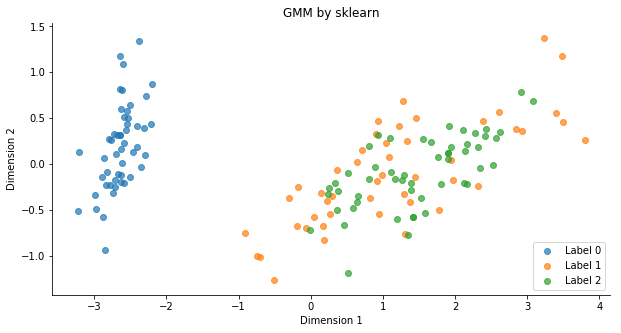

In [22]:
#sklearn viz
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in set(df['skl']):
    plt.scatter(df['dim1'][df['skl']==i],
                df['dim2'][df['skl']==i],
                label=f'Label {int(i)}',alpha=0.7)

plt.title('GMM by sklearn')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc=0)
plt.show()

### Optimal Number of Cluster

&nbsp;

Since Gaussian Mixture Model is based upon multiple Gaussian distributions. Some properties of Gaussian distributions can be borrowed as a metric to determine the optimal numbers of cluster. Both Akaike Information Criterion and Bayesian Information Criterion are up for the job, or proclaimed in the textbook, lol

In [23]:
#compute log likelihood
#basically the expression before jensens inequality in e step
def log_likelihood(data,params):
    
    mean_vec,cov_mat,w_vec=params
    
    likelihood=[
        multivariate_gaussian(data,
                              mean_vec[i],
                              cov_mat[i])*w_vec[i] for i in range(len(w_vec))]
    
    return np.sum(np.log(np.sum(likelihood,axis=0)))

In [24]:
#details of aic can be found in the following link
# http://www.modelselection.org/aic/
def compute_aic(data,params):
    
    return -2*log_likelihood(data,params)+len(data.columns)*2

In [25]:
#details of bic can be found in the following link
# http://www.modelselection.org/bic/
def compute_bic(data,params):
    
    return -2*log_likelihood(data,params)+len(data.columns)*np.log(len(data))

In [26]:
AIC,BIC=[],[]

for num_of_clusters in range(2,10):
    params,posterior=gmm(df,xcols,num_of_clusters)
    AIC.append(compute_aic(df[xcols],params))
    BIC.append(compute_bic(df[xcols],params))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in subtract
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:2022: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


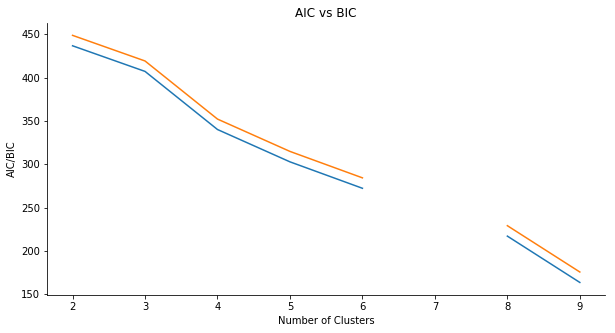

In [27]:
#mmm,neither aic nor bic works in practice
#apparently domain knowledge is the key to success
#otherwise machine learning is merely a state of art
#you can try gap statistic or silhouette score
#but there is no guarantee they give you a clear signal
#details of gap statistic or silhouette score can be found in the link below
# https://github.com/je-suis-tm/machine-learning/blob/master/k%20means.ipynb
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(range(2,10),AIC)
plt.plot(range(2,10),BIC)
plt.xticks(range(2,10))
plt.title('AIC vs BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC/BIC')
plt.show()